In [1]:
%matplotlib inline
import torch
from torch.utils.data import DataLoader
import numpy as np
import cv2 as cv
from ProgressNerf.Registries.DataloaderRegistry import get_dataloader
from ProgressNerf.Registries.RaypickerRegistry import get_raypicker
from ProgressNerf.Registries.RaysamplerRegistry import get_raysampler
from ProgressNerf.Registries.EncoderRegistry import get_encoder
from ProgressNerf.Registries.ModelRegistry import get_model
import ProgressNerf.Dataloading.ToolsPartsDataloader
import ProgressNerf.Raycasting.RandomRaypicker
import ProgressNerf.Raycasting.NearFarRaysampler
import ProgressNerf.Encoders.PositionalEncoder
import ProgressNerf.Raycasting.WeightedRaypicker
import ProgressNerf.Raycasting.PerturbedRaysampler
import ProgressNerf.Models.OGNerf
from ProgressNerf.Architectures.OGNerfArch import OGNerfArch
from ProgressNerf.Utils.CameraUtils import BuildCameraMatrix
import yaml
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

In [2]:
config_file = "./configs/OGNerfArch/toolPartsCoarseFinePerturbedEvalOnly.yml"
arch = OGNerfArch(config_file)

loading config at ./configs/OGNerfArch/toolPartsCoarseFinePerturbedEvalOnly.yml
parsing config
loading ONLY model params from /home/stanlew/Documents/ProgressNerfModels/OGNerf_sigmoid/epoch_3800


In [10]:
test_pose = np.eye(4)
# just a random pose taken from the ToolParts dataset (scene 00_01, test set, sample #8)
test_pose[0:3,3] = np.array([0.052757302998853915, -0.2394366825095671, 1.0026748131467889])
pose_quat = np.array([0.28405447470305767, 0.7107763388551345, 0.5857394722169705, -0.26649450690745147])
rot_matrix = R.from_quat(np.concatenate((pose_quat[1:4], [pose_quat[0]]))).as_matrix()
test_pose[0:3,0:3] = rot_matrix
test_cam_pose = np.linalg.inv(test_pose)

eval_poses = torch.cat((torch.Tensor(test_cam_pose).unsqueeze(0),), dim = 0)

In [11]:
renderings = arch.doEvalRendering(eval_poses)

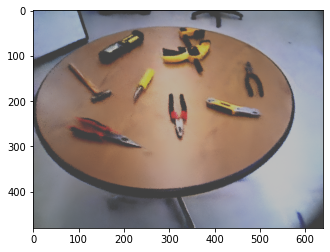

In [12]:
plt.imshow(renderings.cpu()[0].numpy())